In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import seaborn as sns
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook as tqdm

In [2]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [3]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [4]:
z500 = xr.open_mfdataset('geopotential_500/*.nc', combine= 'by_coords').z
z500_test = load_test_data('geopotential_500/', 'z')

In [5]:
# Split into train and test data
# Yes, technically we should have a separate validation set but for LR this shouldn't matter.
data_train = z500.sel(time=slice('1979', '2016'))

# data_train = data.sel(time=slice('2016', '2016'))
data_test = z500.sel(time=slice('2017', '2018'))

In [6]:
# Compute normalization statistics
# Let's only take a sample of the time to speed this up.
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().load()
data_std = data_train.isel(time=slice(0, None, 10000)).std().load()

In [7]:
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

In [8]:
_, nlat, nlon = data_train.shape; nlat, nlon

(32, 64)

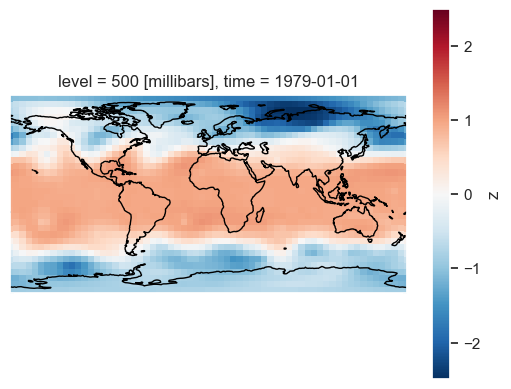

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
data_train.isel(time=0).plot()

plt.show()

In [10]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

In [11]:
def train_lr(X_train, y_train, X_test, y_test, valid_time, lead_time_h, data_subsample= 1):

    lr = LinearRegression(n_jobs = 16)
    lr.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}\nTest MSE = {mse_test}')

    pred = lr.predict(X_test).reshape((-1, 1, nlat, nlon))
    p = xr.DataArray(
        pred[:, 0] * data_std.values + data_mean.values,
        dims= ['time', 'lat', 'lon'],
        coords= {
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name= 'z'
    )
    
    return p, lr



In [12]:
def train_rr(X_train, y_train, X_test, y_test, valid_time, lead_time_h, data_subsample= 1):
    
    rr = Ridge(alpha= 10)
    rr.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, rr.predict(X_train))
    mse_test = mean_squared_error(y_test, rr.predict(X_test))
    print(f'Train MSE = {mse_train}\nTest MSE = {mse_test}')

    pred = rr.predict(X_test).reshape((-1, 1, nlat, nlon))
    p = xr.DataArray(
        pred[:, 0] * data_std.values + data_mean.values,
        dims= ['time', 'lat', 'lon'],
        coords= {
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name= 'z'
    )

    return p, rr

In [13]:
def train_lasso(X_train, y_train, X_test, y_test, valid_time, lead_time_h, data_subsample= 1):
    
    lasso = Lasso(alpha= 100, max_iter= 100)
    lasso.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, lasso.predict(X_train))
    mse_test = mean_squared_error(y_test, lasso.predict(X_test))

    print(f'Train MSE = {mse_train}\nTest MSE = {mse_test}')

    pred = lasso.predict(X_test).reshape((-1, 1, nlat, nlon))
    p = xr.DataArray(
        pred[:, 0] * data_std.values + data_mean.values,
        dims= ['time', 'lat', 'lon'],
        coords= {
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name= 'z'
    )

    return p, lasso

In [35]:
def train_random_forest(X_train, y_train, X_test, y_test, valid_time):
    
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, rf.predict(X_train))
    mse_test = mean_squared_error(y_test, rf.predict(X_test))

    print(f'Train MSE = {mse_train}\nTest MSE = {mse_test}')

    pred = rf.predict(X_test).reshape((-1, 1, nlat, nlon))
    p = xr.DataArray(
        pred[:, 0] * data_std.values + data_mean.values,
        dims= ['time', 'lat', 'lon'],
        coords= {
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name= 'z'
    )

    return p, rf    

## 3 Day Projections

In [14]:
data_subsample = 5
lead_time = 3*24

X_train, y_train, X_test, y_test = [], [], [], []
X, y = create_training_data(data_train, lead_time)

X_train.append(X)
y_train.append(y)
X, y, valid_time = create_training_data(data_test, lead_time, return_valid_time=True)
X_test.append(X)
y_test.append(y)

X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]

X_train = X_train[::data_subsample]
y_train = y_train[::data_subsample]


In [ ]:
p, rr = train_rr(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)
r = compute_weighted_rmse(p, z500_test).compute()
r.values

Train MSE = 0.048138540238142014
Test MSE = 0.05565313622355461


array(681.53433364)

In [ ]:
p.to_netcdf(f'models/rr_3d_z500.nc');
to_pickle(rr, f'models/saved_models/rr_3d_z500.pkl')

In [29]:
p, lasso = train_lasso(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)
r = compute_weighted_rmse(p, z500_test).compute()
r.values

Train MSE = 0.14833804965019226
Test MSE = 0.1405065953731537


array(1074.9609775)

In [31]:
p.to_netcdf('models/lasso_3d_z500.nc');
to_pickle(lasso, 'models/saved_models/lasso_3d_z500.pkl')

In [15]:
three_day_rr = xr.open_mfdataset('models/rr_3d_z500.nc').z
three_day_lasso = xr.open_mfdataset('models/lasso_3d_z500.nc').z

In [13]:
three_day_rr

<xarray.DataArray 'z' (time: 17448, lat: 32, lon: 64)>
dask.array<open_dataset-8faabce9abbb92ce1a486b2e23163e38z, shape=(17448, 32, 64), dtype=float32, chunksize=(17448, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4

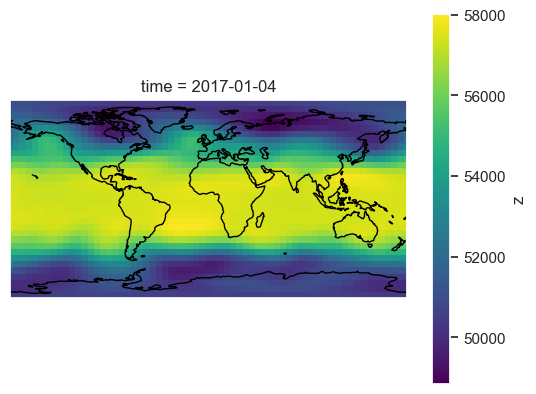

In [16]:
fig, ax = plt.subplots(subplot_kw= {'projection': ccrs.PlateCarree()})
ax.coastlines()

three_day_rr.isel(time= 0).plot()

plt.show()

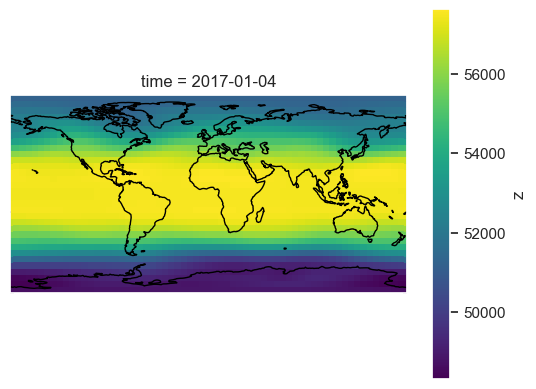

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

three_day_lasso.isel(time= 0).plot()

plt.show()